---
title: "Joint Inversion Using Cross-Gradient Regularization"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar.
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** joint inversion, cross-gradient.

</br>

**Summary:** Here, we consider two geophysical dataset whose diagnostic physical properties are different (e.g. density and magnetic susceptibility). If collected over the same region, we expect independent inversion of these datasets to recover models with similar structure. Here, we demonstrate joint inversion using a cross-gradient regularization can be used to better constrain the structures in the recovered models. For this tutorial, we jointly invert gravity and magnetic data to recover density contrast and magnetic susceptibility models. However, this approach can be applied to any other combination of geophysical datasets.

</br>

**Learning Objectives:**

- Generating a single mesh based on the survey geometry of multiple datasets.
- Generating and combining multiple data misfit and regularization objects.
- Specifying directives for the inversion.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
Functionality for gravity and magnetic simulation are imported the [simpeg.potential_fields.gravity](xref:simpeg#simpeg.potential_fields.gravity) and [simpeg.potential_fields.magnetics](xref:simpeg#simpeg.potential_fields.magnetics) modules, respectively. Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG Functionality
from simpeg.utils import plot2Ddata
from simpeg.potential_fields import gravity, magnetics
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# Discretize functionality
from discretize import TensorMesh
from discretize.utils import active_from_xyz

# Other Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

## Load Tutorial Files

Here, we download and import the data, topography, and other resources into the SimPEG framework. For this tutorial, we have gravity anomaly and total magnetic intensity data that were generated for synthetic density and magnetic susceptibility models, respectively. These files are stored within a Google Cloud bucket. 

In [2]:
# storage bucket where we have the data
data_source = (
    "https://storage.googleapis.com/simpeg/doc-assets/cross_gradient_data.tar.gz"
)

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo.txt"
model_filename = dir_path + "true_model.txt"

overwriting D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\cross_gradient_data.tar.gz
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\cross_gradient_data.tar.gz
Download completed!


In [3]:
# Load topography
xyz_topo = np.loadtxt(topo_filename)

# Load field data
xyz_grav = np.loadtxt(dir_path + "gravity_data.obs")
xyz_mag = np.loadtxt(dir_path + "magnetic_data.obs")

Parse into receiver locations and observed data. In this case, the gravity and magnetic data were simulated at the same locations.

In [4]:
receiver_locations = xyz_grav[:, 0:3]
dobs_grav = xyz_grav[:, -1]
dobs_mag = xyz_mag[:, -1]

## Plot the Observed Data

Here, we plot the observed data and topography.

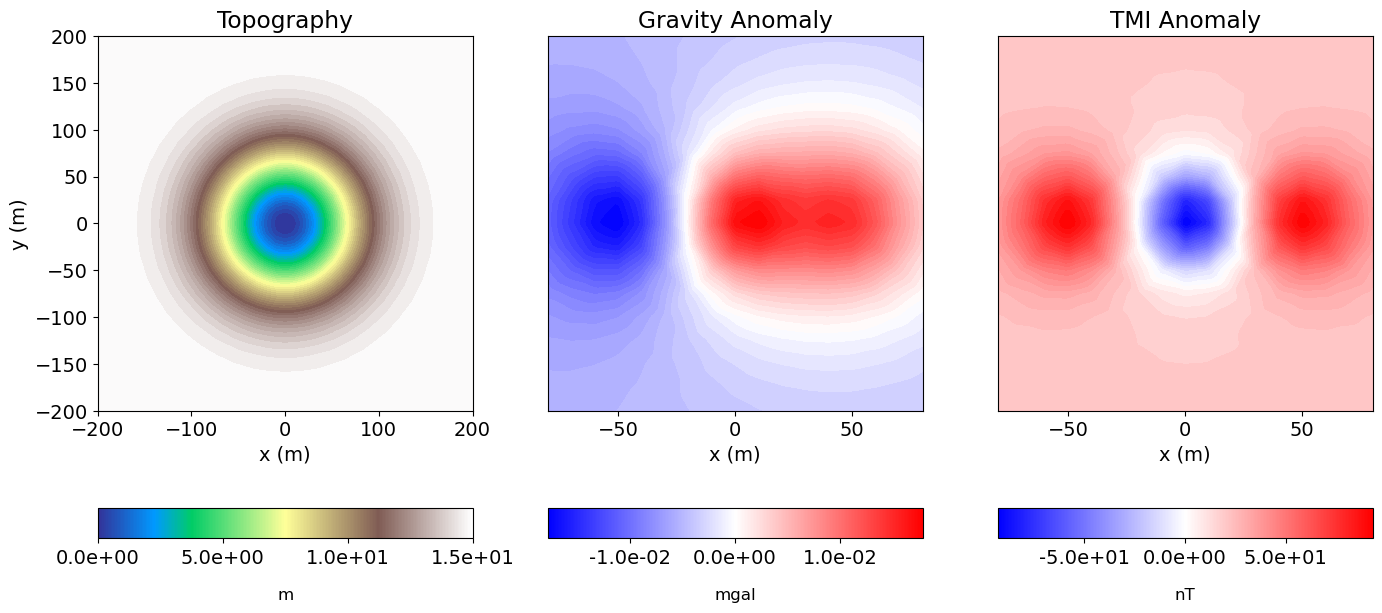

In [5]:
fig = plt.figure(figsize=(15, 6))

data_list = [xyz_topo, xyz_grav, xyz_mag]
title_list = ["Topography", "Gravity Anomaly", "TMI Anomaly"]
cmap_list = [mpl.cm.terrain, mpl.cm.bwr, mpl.cm.bwr]
label_list = ["m", "mgal", "nT"]

ax = [fig.add_axes([0.1+0.3*ii, 0.2, 0.25, 0.75]) for ii in range(3)]
cax = [fig.add_axes([0.1+0.3*ii, 0.05, 0.25, 0.05]) for ii in range(3)]
norm = 3 * [None]
cbar = 3 * [None]

for ii, d in enumerate(data_list):
    
    plot2Ddata(d[:, :2], d[:, -1], ax=ax[ii], ncontour=50, contourOpts={"cmap": cmap_list[ii]})

    ax[ii].set_xlabel("x (m)")
    if ii == 0:
        ax[ii].set_ylabel("y (m)")
        norm[ii] = mpl.colors.Normalize(vmin=-np.min(d[:, -1]), vmax=np.max(d[:, -1]))
    else:
        ax[ii].set_yticks([])
        norm[ii] = mpl.colors.Normalize(
            vmin=-np.max(np.abs(d[:, -1])), vmax=np.max(np.abs(d[:, -1]))
        )
    ax[ii].set_title(title_list[ii])
    
    cbar[ii] = mpl.colorbar.ColorbarBase(
        cax[ii], norm=norm[ii], orientation="horizontal", cmap=cmap_list[ii], format="%.1e"
    )
    cbar[ii].set_label(label_list[ii], rotation=0, labelpad=15, size=12)

## Assign Uncertainties

Here, we must assign uncertainties to our datasets. Standard approaches for
applying uncertainties to different datasets are described in basic inversion
tutorials. For instance, see the
[3D Inversion of Gravity Anomaly Data](../03-gravity/inv_gravity_anomaly_3d.ipynb) and
[3D Inversion of TMI Data to Recover a Susceptibility Model](../04-magnetic/inv_tmi_anomaly_3d.ipynb) notebooks.

For this tutorial, the uncertainty on each gravity anomaly datum will be 1% of the
maximum observed gravity anomaly value. For magnetic inversion, the same strategy is performed.

In [6]:
maximum_anomaly_grav = np.max(np.abs(dobs_grav))
uncertainties_grav = 0.01 * maximum_anomaly_grav * np.ones(np.shape(dobs_grav))

maximum_anomaly_mag = np.max(np.abs(dobs_mag))
uncertainties_mag = 0.01 * maximum_anomaly_mag * np.ones(np.shape(dobs_mag))

## Defining the Survey

Here, we define the survey geometries for the dataset that are being inverted jointly.
For this tutorial, we must define a gravity anomaly and a total magnetic intensity survey.
Instructions for designing these surveys are found in the
[Forward Simulation of Gravity Anomaly Data](../03-gravity/inv_gravity_anomaly_3d.ipynb) and
[Forward Simulation of TMI Data](../04-magnetic/fwd_magnetics_inducted_3d.ipynb) notebooks.

In [7]:
# DEFINE GRAVITY SURVEY
# The data consist of vertical gravity anomaly measurements.
receiver_grav = gravity.receivers.Point(receiver_locations, components="gz")

# Define the source field and survey for gravity data
source_field_grav = gravity.sources.SourceField(receiver_list=[receiver_grav])
survey_grav = gravity.survey.Survey(source_field_grav)

In [8]:
# DEFINE MAGNETICS SURVEY
# The data are total magnetic intensity data.
components = ["tmi"]

# Define the receivers
receiver_mag = magnetics.receivers.Point(receiver_locations, components=components)

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000

# Define the source field and survey for gravity data
source_field_mag = magnetics.sources.UniformBackgroundField(
    receiver_list=[receiver_mag],
    amplitude=strength,
    declination=declination,
    inclination=inclination,
)
survey_mag = magnetics.survey.Survey(source_field_mag)

## Defining the Data

Here, we define a SimPEG [Data](xref:simpeg#simpeg.data.Data) object for each dataset that is inverted.
Recall that data objects connect the observed data, uncertainties and survey geometry.

In [9]:
# Gravity data object
data_object_grav = data.Data(
    survey_grav, dobs=dobs_grav, standard_deviation=uncertainties_grav
)

# Magnetic data object
data_object_mag = data.Data(
    survey_mag, dobs=dobs_mag, standard_deviation=uncertainties_mag
)

## Defining a Tensor Mesh for Joint Inversion

Here, the user must generate a **single mesh** that is appropriate for simulating
the physics for **all** datasets being inverted. Standardized approaches for
designing meshes for each data type are provided in basic inversion notebooks.
For examples, see the
[3D Inversion of Gravity Anomaly Data](../03-gravity/inv_gravity_anomaly_3d.ipynb),
[3D Inversion of TMI Data to Recover a Susceptibility Model](../04-magnetic/inv_tmi_anomaly_3d.ipynb), and
[3D DC Resistivity Inversion](../05-dcr/inv_dcr_3d.ipynb) notebooks.

Here, we create the tensor mesh that will be used to invert the gravity anomaly
and TMI anomaly data provided. These two data types work well for joint inversion
because they can frequently be used to resolve structures on the same scale.
If desired, we could define an OcTree mesh instead.

In [10]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

## Starting/Reference Model and Mapping on Tensor Mesh

Here, we create starting and/or reference models for the inversion.
We also define the mapping from the model vector to the physical properties
defined on the mesh. For potential fields, we map from the model to the active cells.
For electromagnetic simulations, we map from the model to all mesh cells.
See [simpeg.maps.IdentityMap](xref:simpeg#simpeg.maps.IdentityMap) and other
mappings for more.

For this tutorial, the model consists of the densities (g/cc) and the magnetic
susceptibilities (SI) for all cells that lie before the surface topography.
The model vector is therefore organized $[\mathbf{m_\rho}, \; \mathbf{m_\chi}]$.
Starting and reference model values of 1e-6 g/cc and 1e-6 SI are used for the
density and susceptibility, respectively. Note that the background values could
be different for density and susceptibility models.

In [ ]:
# Find the indicies of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Number of model parameters for each physical property type
nP = int(ind_active.sum())

In [11]:
# Define mapping from model to active cells (potential fields) or all cells (electromagnetics)
active_map = maps.IdentityMap(nP=nP)  # model consists of a value for each active cell

# Create Wires Map that maps from stacked models to individual model components
# m1 refers to density model, m2 refers to susceptibility
wires = maps.Wires(("density", nP), ("susceptibility", nP))

In [ ]:
# Define density contrast values for each unit
starting_density, starting_susceptibility = 1e-6, 1e-6

# Define and plot starting model
starting_model = np.r_[starting_density * np.ones(nP), starting_susceptibility * np.ones(nP)]

## Define the Forward Simulations

Here, we define the physics of the gravity and magnetic problems by using the simulation
class.




In [12]:
simulation_grav = gravity.simulation.Simulation3DIntegral(
    survey=survey_grav,
    mesh=mesh,
    rhoMap=wires.density,
    active_cells=ind_active,
    engine="choclo",
)

In [13]:
simulation_mag = magnetics.simulation.Simulation3DIntegral(
    survey=survey_mag,
    mesh=mesh,
    model_type="scalar",
    chiMap=wires.susceptibility,
    active_cells=ind_active,
    engine="choclo",
)

## Define the Inverse Problem

The inverse problem is defined by 4 things:

1) **Data Misfit:** a measure of how well our recovered model explains the field data
2) **Regularization:** constraints placed on the recovered model and a priori information
3) **Coupling:** a connection of two different physical property models
4) **Optimization:** the numerical approach used to solve the inverse problem

### Data Misfit

Define the data misfit for each dataset separately. Here the data misfit is the L2 norm of the weighted
residual between the observed data and the data predicted for a given model.
Within the data misfit, the residual between predicted and observed data are
normalized by the data's standard deviation.

In [ ]:
# Define a data misfit for each dataset
dmis_grav = data_misfit.L2DataMisfit(data=data_object_grav, simulation=simulation_grav)
dmis_mag = data_misfit.L2DataMisfit(data=data_object_mag, simulation=simulation_mag)

# Add to make a combo objective function
dmis = dmis_grav + dmis_mag

### Regularization

In [14]:
# Define the regularization (model objective function).
reg_grav = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.density
)
reg_mag = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.susceptibility
)

# Define the coupling term to connect two different physical property models
lamda = 2e12  # weight for coupling term
cross_grad = regularization.CrossGradient(mesh, wires, active_cells=ind_active)

# combo
reg = reg_grav + reg_mag + lamda * cross_grad

### Optimization and Inverse Problem

In [ ]:
# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10,
    lower=-2.0,
    upper=2.0,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-3,
    tolX=1e-3,
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [15]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.PairedBetaEstimate_ByEig(beta0_ratio=1e0)
# starting_beta.n_pw_iter = 10

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.PairedBetaSchedule(cooling_factor=5, cooling_rate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SimilarityMeasureSaveOutputEveryIteration(save_txt=False)

joint_inv_dir = directives.SimilarityMeasureInversionDirective()

stopping = directives.MovingAndMultiTargetStopping(tol=1e-6)

sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()


# The directives are defined as a list.
directives_list = [
    joint_inv_dir,
    sensitivity_weights,
    stopping,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [16]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================================================ Projected GNCG ============================================================
  #            betas             lambda      f               phi_d                     phi_m            phi_sim    iterCG    Comment   
---------------------------------------------------------------------------------------------------------------------------------------
x0 has any nan: 0
   0  ['8.55e+04', '3.24e+04']  2.00e+12  4.55e+05             []                        []             0.00e+00      0   

model has any nan: 0
============================================================ Projected GNCG ============================================================
  #            betas             lambda      f               phi_d                     phi_m            phi_sim    iterCG    Comment   
---------------------------------------------------------------------------------------------------------------------------------------
x0 has any nan: 0


   0  ['8.42e+04', '3.23e+04']  2.00e+12  4.55e+05             []                        []             0.00e+00      0                


   1  ['1.68e+04', '6.46e+03']  2.00e+12  2.24e+04  ['1.30e+04', '3.31e+02']  ['3.75e-01', '1.64e-01']  8.88e-10    100                


   2  ['3.37e+03', '8.61e+03']  2.00e+12  8.46e+03  ['3.41e+03', '9.47e+01']  ['5.84e-01', '1.74e-01']  7.48e-10    100     Skip BFGS  


   3  ['6.73e+02', '1.15e+04']  2.00e+12  5.29e+03  ['1.55e+03', '5.73e+01']  ['7.34e-01', '1.72e-01']  6.10e-10    100     Skip BFGS  


   4  ['1.35e+02', '1.53e+04']  2.00e+12  4.78e+03  ['1.01e+03', '6.85e+01']  ['8.03e-01', '1.68e-01']  5.05e-10    100     Skip BFGS  


   5  ['2.69e+01', '2.04e+04']  2.00e+12  5.09e+03  ['7.78e+02', '9.53e+01']  ['8.62e-01', '1.64e-01']  4.21e-10    100                


   6  ['5.39e+00', '2.72e+04']  2.00e+12  5.85e+03  ['6.33e+02', '1.26e+02']  ['8.86e-01', '1.61e-01']  3.49e-10    100                


   7  ['1.08e+00', '3.55e+04']  2.00e+12  6.91e+03  ['5.42e+02', '2.22e+02']  ['9.23e-01', '1.55e-01']  3.16e-10    100                


   8  ['2.16e-01', '7.10e+03']  2.00e+12  2.38e+03  ['4.74e+02', '3.24e+02']  ['9.32e-01', '1.51e-01']  2.55e-10    100                


   9  ['4.31e-02', '9.47e+03']  2.00e+12  2.49e+03  ['3.73e+02', '3.84e+01']  ['9.64e-01', '1.66e-01']  2.53e-10    100                


  10  ['8.62e-03', '1.26e+04']  2.00e+12  2.90e+03  ['3.53e+02', '5.55e+01']  ['9.73e-01', '1.64e-01']  2.09e-10    100                
------------------------- STOP! -------------------------
1 : maxIter   =      10    <= iter          =     10
------------------------- DONE! -------------------------


## Plotting True Model and Recovered Model




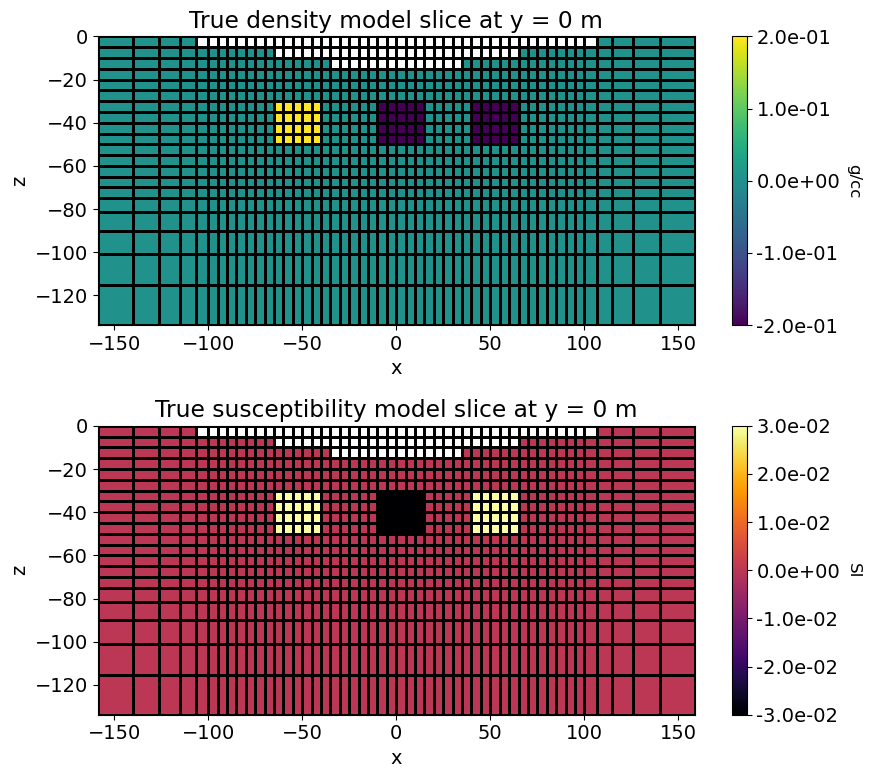

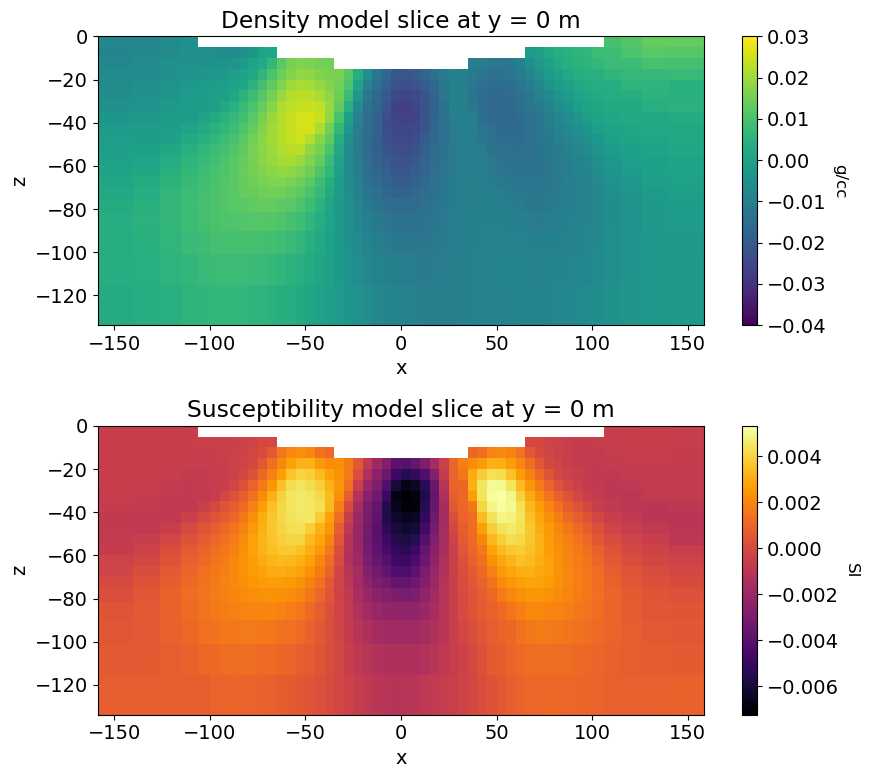

In [17]:
# Load the true model (was defined on the whole mesh) and extract only the
# values on active cells.

true_model_dens = np.loadtxt(dir_path + "true_model_dens.txt")
true_model_dens[~ind_active] = np.nan

true_model_susc = np.loadtxt(dir_path + "true_model_susc.txt")
true_model_susc[~ind_active] = np.nan

# Plot True Model
fig = plt.figure(figsize=(9, 8))
ax1 = plt.subplot(211)

(im,) = mesh.plot_slice(true_model_dens, normal="Y", ax=ax1, grid=True)
ax1.set_title("True density model slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(212)
(im,) = mesh.plot_slice(
    true_model_susc, normal="Y", ax=ax2, grid=True, pcolor_opts={"cmap": "inferno"}
)

ax2.set_title("True susceptibility model slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("SI", rotation=270, labelpad=15, size=12)
plt.tight_layout()
plt.show()

# Plot Recovered Model
m_dens_joint, m_susc_joint = wires * recovered_model
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

fig = plt.figure(figsize=(9, 8))
ax1 = plt.subplot(211)
(im,) = mesh.plot_slice(
    plotting_map * m_dens_joint,
    normal="Y",
    ax=ax1,
    clim=(-0.04, 0.03),
)
ax1.set_title("Density model slice at y = 0 m")
cbar = plt.colorbar(im)
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(212)
(im,) = mesh.plot_slice(
    plotting_map * m_susc_joint, normal="Y", ax=ax2, pcolor_opts={"cmap": "inferno"}
)
ax2.set_title("Susceptibility model slice at y = 0 m")
cbar = plt.colorbar(im)
cbar.set_label("SI", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

## Comparing jointly and separatly recovered models




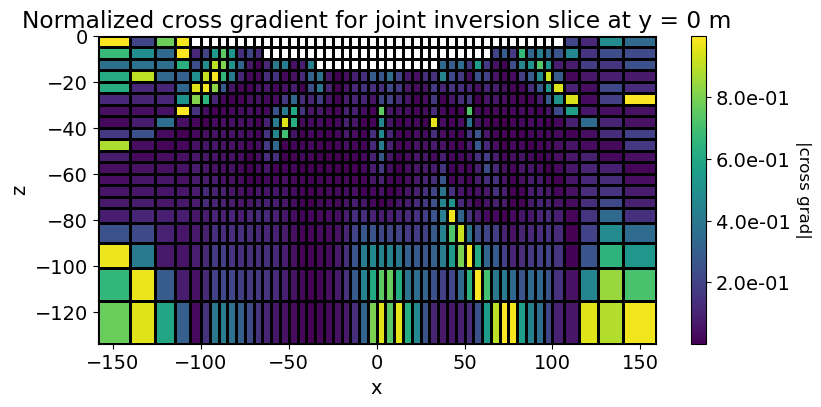

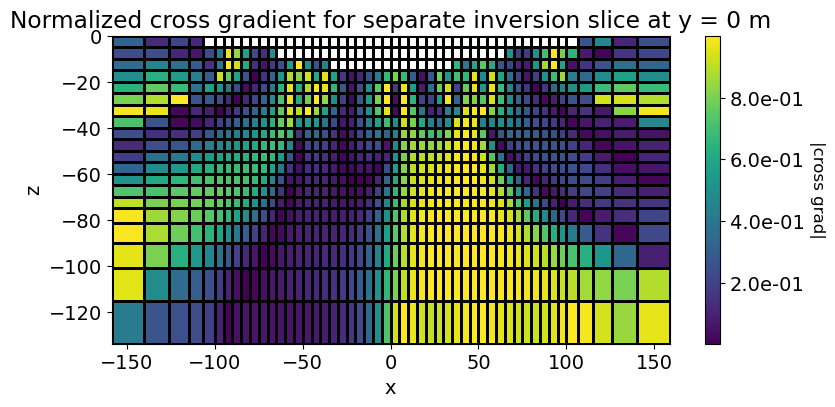

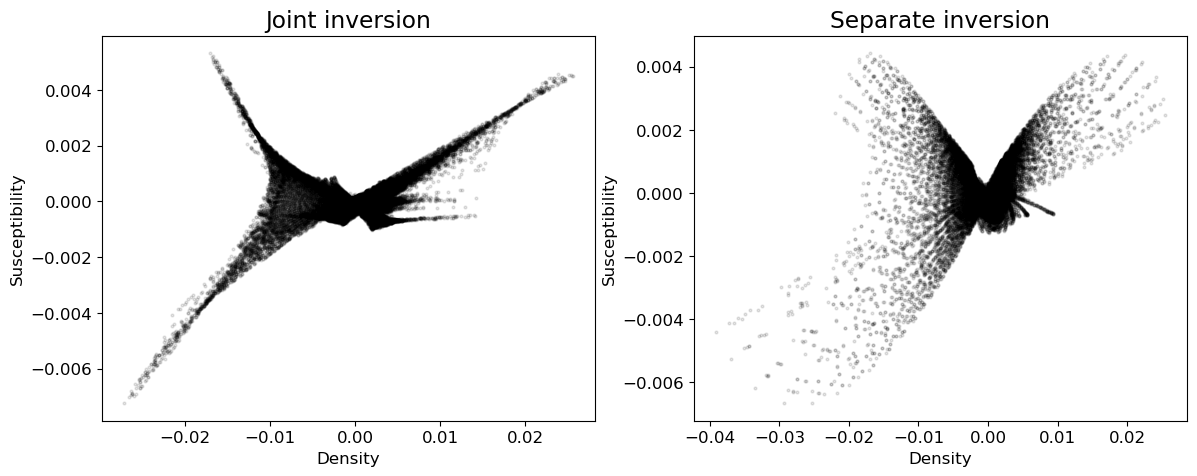

In [18]:
# Normalized Cross Gradient of Jointly Recovered Susceptibility and Density Models
ncg = cross_grad.calculate_cross_gradient(recovered_model, normalized=True)

fig = plt.figure(figsize=(9, 4))
ax = plt.subplot(111)
(im,) = mesh.plot_slice(
    plotting_map * ncg,
    normal="Y",
    ax=ax,
    grid=True,
)
ax.set_title("Normalized cross gradient for joint inversion slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("|cross grad|", rotation=270, labelpad=15, size=12)
plt.show()

# Normalized Cross Gradient of Separately Recovered Susceptibility and Density Models
m_dens_single = np.loadtxt(dir_path + "single_model_dens.txt")
m_susc_single = np.loadtxt(dir_path + "single_model_susc.txt")
m_separate = np.r_[m_dens_single[ind_active], m_susc_single[ind_active]]

ncg_single = cross_grad.calculate_cross_gradient(m_separate, normalized=True)

fig = plt.figure(figsize=(9, 4))
ax = plt.subplot(111)
(im,) = mesh.plot_slice(
    plotting_map * ncg_single,
    normal="Y",
    ax=ax,
    grid=True,
)
ax.set_title("Normalized cross gradient for separate inversion slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("|cross grad|", rotation=270, labelpad=15, size=12)

plt.show()


# Cross Plots Recovered Susceptibility and Density Models
fig = plt.figure(figsize=(14, 5))
ax0 = plt.subplot(121)
ax0.scatter(
    plotting_map * m_dens_joint, plotting_map * m_susc_joint, s=4, c="black", alpha=0.1
)

ax0.set_xlabel("Density", size=12)
ax0.set_ylabel("Susceptibility", size=12)
ax0.tick_params(labelsize=12)
ax0.set_title("Joint inversion")

ax1 = plt.subplot(122)
ax1.scatter(m_dens_single, m_susc_single, s=4, c="black", alpha=0.1)

ax1.set_xlabel("Density", size=12)
ax1.set_ylabel("Susceptibility", size=12)
ax1.tick_params(labelsize=12)
ax1.set_title("Separate inversion")

plt.show()